# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, Binarizer

%matplotlib inline


# Import Dataset

In [2]:
x = pd.read_csv('titanic_train.csv')
y = x.pop('Survived')

In [3]:
x.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

# Data Cleaning

In [5]:
x.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
x.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
x.drop(['PassengerId', 'Name', 'Ticket'], inplace=True, axis=1)
x.Age.fillna(x.Age.median(), inplace=True)
x.Cabin.fillna('None', inplace = True)
x.Embarked.fillna('None', inplace = True)
x.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64

In [8]:
x[x.isna().any(axis = 1)]

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked


In [9]:
numerical_variable = []
categorical_variable = []
for i in x.columns:
    if x[i].dtype != object:
        numerical_variable.append(i)
    else:
        categorical_variable.append(i)

In [10]:
numerical_variable

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [11]:
categorical_variable

['Sex', 'Cabin', 'Embarked']

In [12]:
for var in categorical_variable:
    dummies = pd.get_dummies(x[var], prefix=var)
    x = pd.concat([x, dummies], axis=1)
    x.drop(var,axis=1,inplace=True)

In [13]:
x.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A10,Cabin_A14,Cabin_A16,...,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_None,Cabin_T,Embarked_C,Embarked_None,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1


# Data Analysis

## Split into Train & Test set

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(x, y, test_size=0.20, random_state=42)

## Train on Numeric Features

In [15]:
X_numeric = X_train[numerical_variable]
X_numeric.head()

,Pclass,Age,SibSp,Parch,Fare
331,1,45.5,0,0,28.5000
733,2,23.0,0,0,13.0000
382,3,32.0,0,0,7.9250
704,3,26.0,1,0,7.8542
813,3,6.0,4,2,31.2750


In [16]:
model_1 = RandomForestClassifier(oob_score=True, random_state=42)
model_1.fit(X_numeric, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

### Out-of-Bag Score (Built in Cross Validation)

In [17]:
print('The OOB score : {0}'.format(model_1.oob_score_))

The OOB score : 0.6657303370786517


### Cross Validation Score

In [18]:
results = cross_val_score(model_1, X_numeric, y_train, scoring='accuracy')
print(f'Cross Validation Score: {results.mean()}')

Cross Validation Score: 0.6784792672116614


### AUC Score

In [19]:
pred_train = np.argmax(model_1.oob_decision_function_, axis = 1)
numeric_auc = roc_auc_score(y_train,pred_train)
numeric_auc

0.6358410649455426

## Train on Categorical and Numerical Features

In [20]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A10,Cabin_A14,Cabin_A16,...,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_None,Cabin_T,Embarked_C,Embarked_None,Embarked_Q,Embarked_S
331,1,45.5,0,0,28.5000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
733,2,23.0,0,0,13.0000,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
382,3,32.0,0,0,7.9250,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
704,3,26.0,1,0,7.8542,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
813,3,6.0,4,2,31.2750,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [21]:
model_2 = RandomForestClassifier(oob_score=True, random_state=42)
model_2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

### OOB score:

In [22]:
print(f'OBB score is :{model_2.oob_score_}')

OBB score is :0.800561797752809


### Feature Scalling:
Does feature scalling affets the performance ? Is it necessary for tree based model ?
Lets Check

In [23]:
X_scaled = StandardScaler().fit(X_train).transform(X_train)
X_scaled

array([[-1.61413602,  1.25364106, -0.47072241, ..., -0.05307449,
        -0.30335547,  0.59681695],
       [-0.40055118, -0.47728355, -0.47072241, ..., -0.05307449,
        -0.30335547,  0.59681695],
       [ 0.81303367,  0.21508629, -0.47072241, ..., -0.05307449,
        -0.30335547,  0.59681695],
       ...,
       [ 0.81303367,  0.90745614,  1.23056874, ..., -0.05307449,
        -0.30335547,  0.59681695],
       [-1.61413602, -1.1696534 ,  0.37992316, ..., -0.05307449,
        -0.30335547,  0.59681695],
       [-1.61413602, -0.63114352, -0.47072241, ..., -0.05307449,
        -0.30335547,  0.59681695]])

In [24]:
model_3 = RandomForestClassifier(oob_score=True, random_state=40)
model_3.fit(X_scaled,y_train)
print(f'OOB score for scaled features model is: {model_3.oob_score_}')

OOB score for scaled features model is: 0.8103932584269663


From this OOB score comparision, we can conclude that feature scaling does not affect much on random forest model.

### AUC Score:

In [25]:
pred_train = np.argmax(model_2.oob_decision_function_, axis =1)
print(f'roc_auc score: {roc_auc_score(y_train,pred_train)}')
cat_auc_score = roc_auc_score(y_train,pred_train)

roc_auc score: 0.7757496302272422


## Baseline RF Model Evalution (ROC AUC)

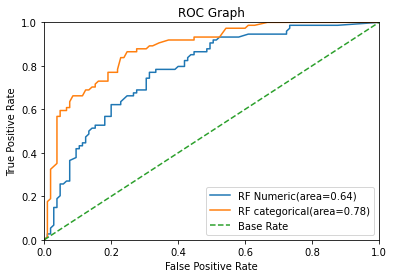

In [26]:
from sklearn.metrics import roc_curve

rf_numeric_fpr, rf_numeric_tpr, rf_numeric_thresholds = roc_curve(y_test, model_1.predict_proba(X_test[X_numeric.columns])[:,1])
rf_cat_fpr, rf_cat_tpr, rf_cat_thresholds = roc_curve(y_test, model_2.predict_proba(X_test[X_train.columns])[:,1])

plt.plot(rf_numeric_fpr, rf_numeric_tpr, label=f'RF Numeric(area={numeric_auc:1.2})')
plt.plot(rf_cat_fpr, rf_cat_tpr, label=f'RF categorical(area={cat_auc_score:1.2})')
plt.plot([0,1],[0,1], ls='--', label='Base Rate')

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc='lower right')
plt.show()

## Important Parameters
***
### Parameters that will make your model better
- **max_depth:** The depth size of a tree
- **n_estimators:** The number of trees in the forest. Generally, the more trees the better accuracy, but slower computation.
- **max_features**: The max number of features that the algorithm can assign to an individual tree. Try ['auto', 'None', 'sqrt', 'log2', 0.9 and 0.2]
- **min_samples_leaf:** The minimum number of samples in newly created leaves. Try [1,2,3]. If 3 is best, try higher numbers.

### Parameters that will make your model faster
- **n_jobs**: Determines the amount of multiple processors should be used to train/test the model. Always use -1 to use max cores and it'll run much faster
- **random_state**: Set this to a number (42) for reproducibility. It's used to replicate your results and for others as well.
- **oob_score** Random Forest's custom validation method: out-of-bag prediction

### max_depth

More the depth (deeper the tree) means higher chances of overfitting

max_depth: 1
AUC Train: 0.5 
 AUC Test: 0.5

max_depth: 2
AUC Train: 0.627 
 AUC Test: 0.628

max_depth: 3
AUC Train: 0.737 
 AUC Test: 0.738

max_depth: 4
AUC Train: 0.752 
 AUC Test: 0.737

max_depth: 5
AUC Train: 0.804 
 AUC Test: 0.79

max_depth: 10
AUC Train: 0.87 
 AUC Test: 0.788

max_depth: 20
AUC Train: 0.96 
 AUC Test: 0.795

max_depth: 50
AUC Train: 0.98 
 AUC Test: 0.774

max_depth: 100
AUC Train: 0.98 
 AUC Test: 0.774



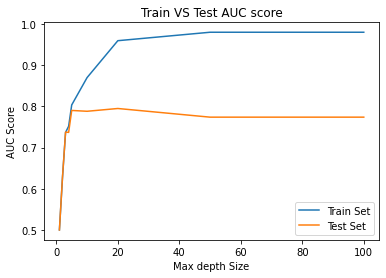

In [27]:
train_result = []
test_result = []
max_depth_size = [1,2,3,4,5,10,20,50,100]

for max_depth in max_depth_size:
    model = RandomForestClassifier(max_depth=max_depth, oob_score=True, n_jobs=1, random_state=44)
    model.fit(X_train,y_train)
    print(f'max_depth: {max_depth}')
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_roc = roc_auc_score(y_train, train_pred)
    test_roc = roc_auc_score(y_test, test_pred)
    train_result.append(train_roc)
    test_result.append(test_roc)
    print(f'AUC Train: {train_roc:0.3} \n AUC Test: {test_roc:0.3}\n')
    
plt.plot(max_depth_size, train_result, label='Train Set')
plt.plot(max_depth_size, test_result, label='Test Set')
plt.xlabel('Max depth Size')
plt.ylabel('AUC Score')
plt.title('Train VS Test AUC score')
plt.legend(loc='lower right')
plt.show()

### n_estimators

Generally the more trees the better. You'll generalize better with more trees and reduce the variance more. The only downside is computation time.

c:\python\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\python\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\python\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\python\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\python\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  w

No of Trees: 1
AUC Score: 0.669 

No of Trees: 2
AUC Score: 0.687 

No of Trees: 3
AUC Score: 0.736 

No of Trees: 4
AUC Score: 0.753 

No of Trees: 5
AUC Score: 0.76 

No of Trees: 10
AUC Score: 0.801 



c:\python\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\python\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


No of Trees: 15
AUC Score: 0.796 

No of Trees: 20
AUC Score: 0.798 

No of Trees: 25
AUC Score: 0.801 

No of Trees: 40
AUC Score: 0.803 

No of Trees: 50
AUC Score: 0.801 

No of Trees: 70
AUC Score: 0.803 

No of Trees: 90
AUC Score: 0.803 

No of Trees: 100
AUC Score: 0.801 



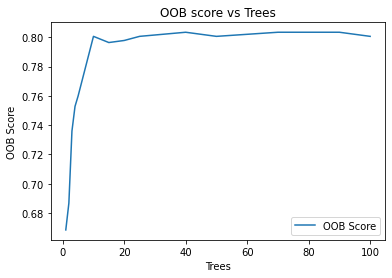

In [28]:
results = []
n_estimators_option = [1,2,3,4,5,10,15,20,25,40,50,70,90,100]

for trees in n_estimators_option:
    model = RandomForestClassifier(n_estimators=trees, oob_score=True, random_state=42)
    model.fit(X_train, y_train)
    print(f'No of Trees: {trees}')
    auc = model.oob_score_
    print(f'AUC Score: {auc:0.3} \n')
    results.append(auc)

plt.plot(n_estimators_option, results, label='OOB Score')
plt.xlabel('Trees')
plt.ylabel('OOB Score')
plt.title('OOB score vs Trees')
plt.legend(loc = 'lower right')
plt.show()

### max_features:

Maximum feature option: auto
AUC score: 0.8033707865168539 

Maximum feature option: None
AUC score: 0.8103932584269663 

Maximum feature option: sqrt
AUC score: 0.8033707865168539 

Maximum feature option: log2
AUC score: 0.8061797752808989 

Maximum feature option: 0.7
AUC score: 0.8117977528089888 

Maximum feature option: 0.2
AUC score: 0.8146067415730337 



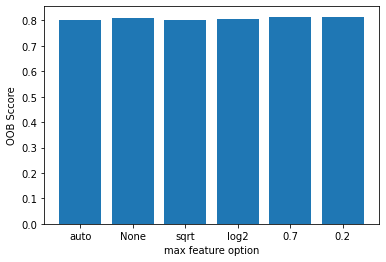

In [29]:
results = []
max_features_options = ['auto', None, 'sqrt', 'log2', 0.7, 0.2]
for max_features in max_features_options:
    model = RandomForestClassifier(max_features=max_features, oob_score=True, random_state=42, n_jobs=1, n_estimators=1000)
    model.fit(X_train, y_train)
    print(f'Maximum feature option: {max_features}')
    auc_score = model.oob_score_
    print(f'AUC score: {auc_score} \n')
    results.append(auc_score)
    
max_features_options[1] = 'None'
index = list(range(len(max_features_options)))
plt.bar(index, results)
plt.xlabel('max feature option')
plt.ylabel('OOB Sccore')
plt.xticks(index, max_features_options)
plt.show()

### Min Sample Leafs

minimum sample leafs: 1
auc score: 0.803 

minimum sample leafs: 2
auc score: 0.819 

minimum sample leafs: 3
auc score: 0.789 

minimum sample leafs: 4
auc score: 0.791 

minimum sample leafs: 5
auc score: 0.789 

minimum sample leafs: 6
auc score: 0.791 

minimum sample leafs: 7
auc score: 0.791 

minimum sample leafs: 8
auc score: 0.785 

minimum sample leafs: 9
auc score: 0.789 

minimum sample leafs: 10
auc score: 0.785 

minimum sample leafs: 20
auc score: 0.765 



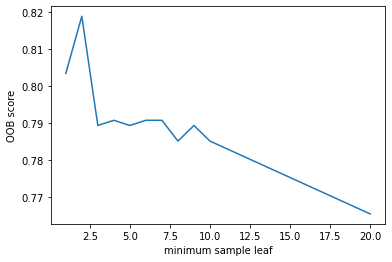

In [30]:
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,20]

for min_samples in min_samples_leaf_options:
    model = RandomForestClassifier(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42, max_features="auto", min_samples_leaf=min_samples)
    model.fit(X_train, y_train)
    auc = model.oob_score_
    results.append(auc)
    print(f'minimum sample leafs: {min_samples}')
    print(f'auc score: {auc:0.3} \n')

plt.plot(min_samples_leaf_options, results)
plt.xlabel('minimum sample leaf')
plt.ylabel('OOB score')
plt.show()

## Understanding Random Forest In-depth

In [31]:
# The amount of trees used to ensemble
model_2.estimators_

[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1608637542, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1273642419, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, 

### Understanding Single Decision Tree

In [32]:
df = pd.read_csv('titanic_train.csv')
df.Survived.value_counts(1) #gives in percentage

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [33]:
X_train.shape

(712, 159)

#### Each node in a tree contains:
1. The splitting criteria of the attribute (Sex_male <= 0.5)
2. Has the bootstrap sample (ex. 451/712 --> 67% of the data)
3. Class value of the sample (ex. [448, 264] --> 448 0's, 264 1's)
4. Final class outcome (classification is majority vote, regression is MSE)
5. Cost Function (Gini - used to interpret how good of a split we made)

##### Gini 
- We use the Gini Index as our cost function used to evaluate splits in the dataset.
- A Gini score gives an idea of how good a split is by how mixed the classes are in the two groups created by the split. 
- A perfect separation results in a Gini score of 0 (ex. [0,25])
- Whereas the worst case split that results in 50/50 classes.

#### Visualize the decision tree

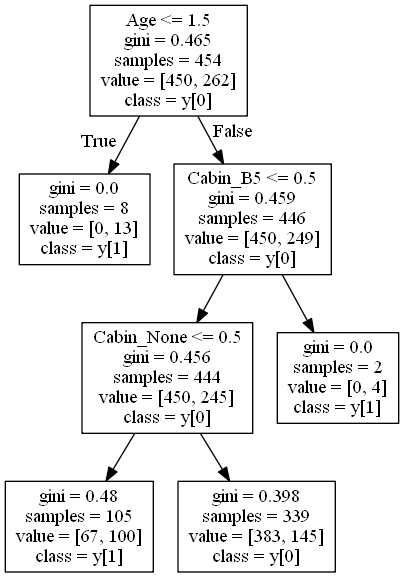

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from IPython.display import Image
from sklearn import tree
import pydotplus

rfc = RandomForestClassifier(n_estimators=1, max_depth=3)
rfc.fit(X_train, y_train)

dot_data = tree.export_graphviz(rfc.estimators_[0], out_file=None, feature_names=X_train.columns, class_names=True)

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

#### Visualize Entire Decision Tree

c:\python\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


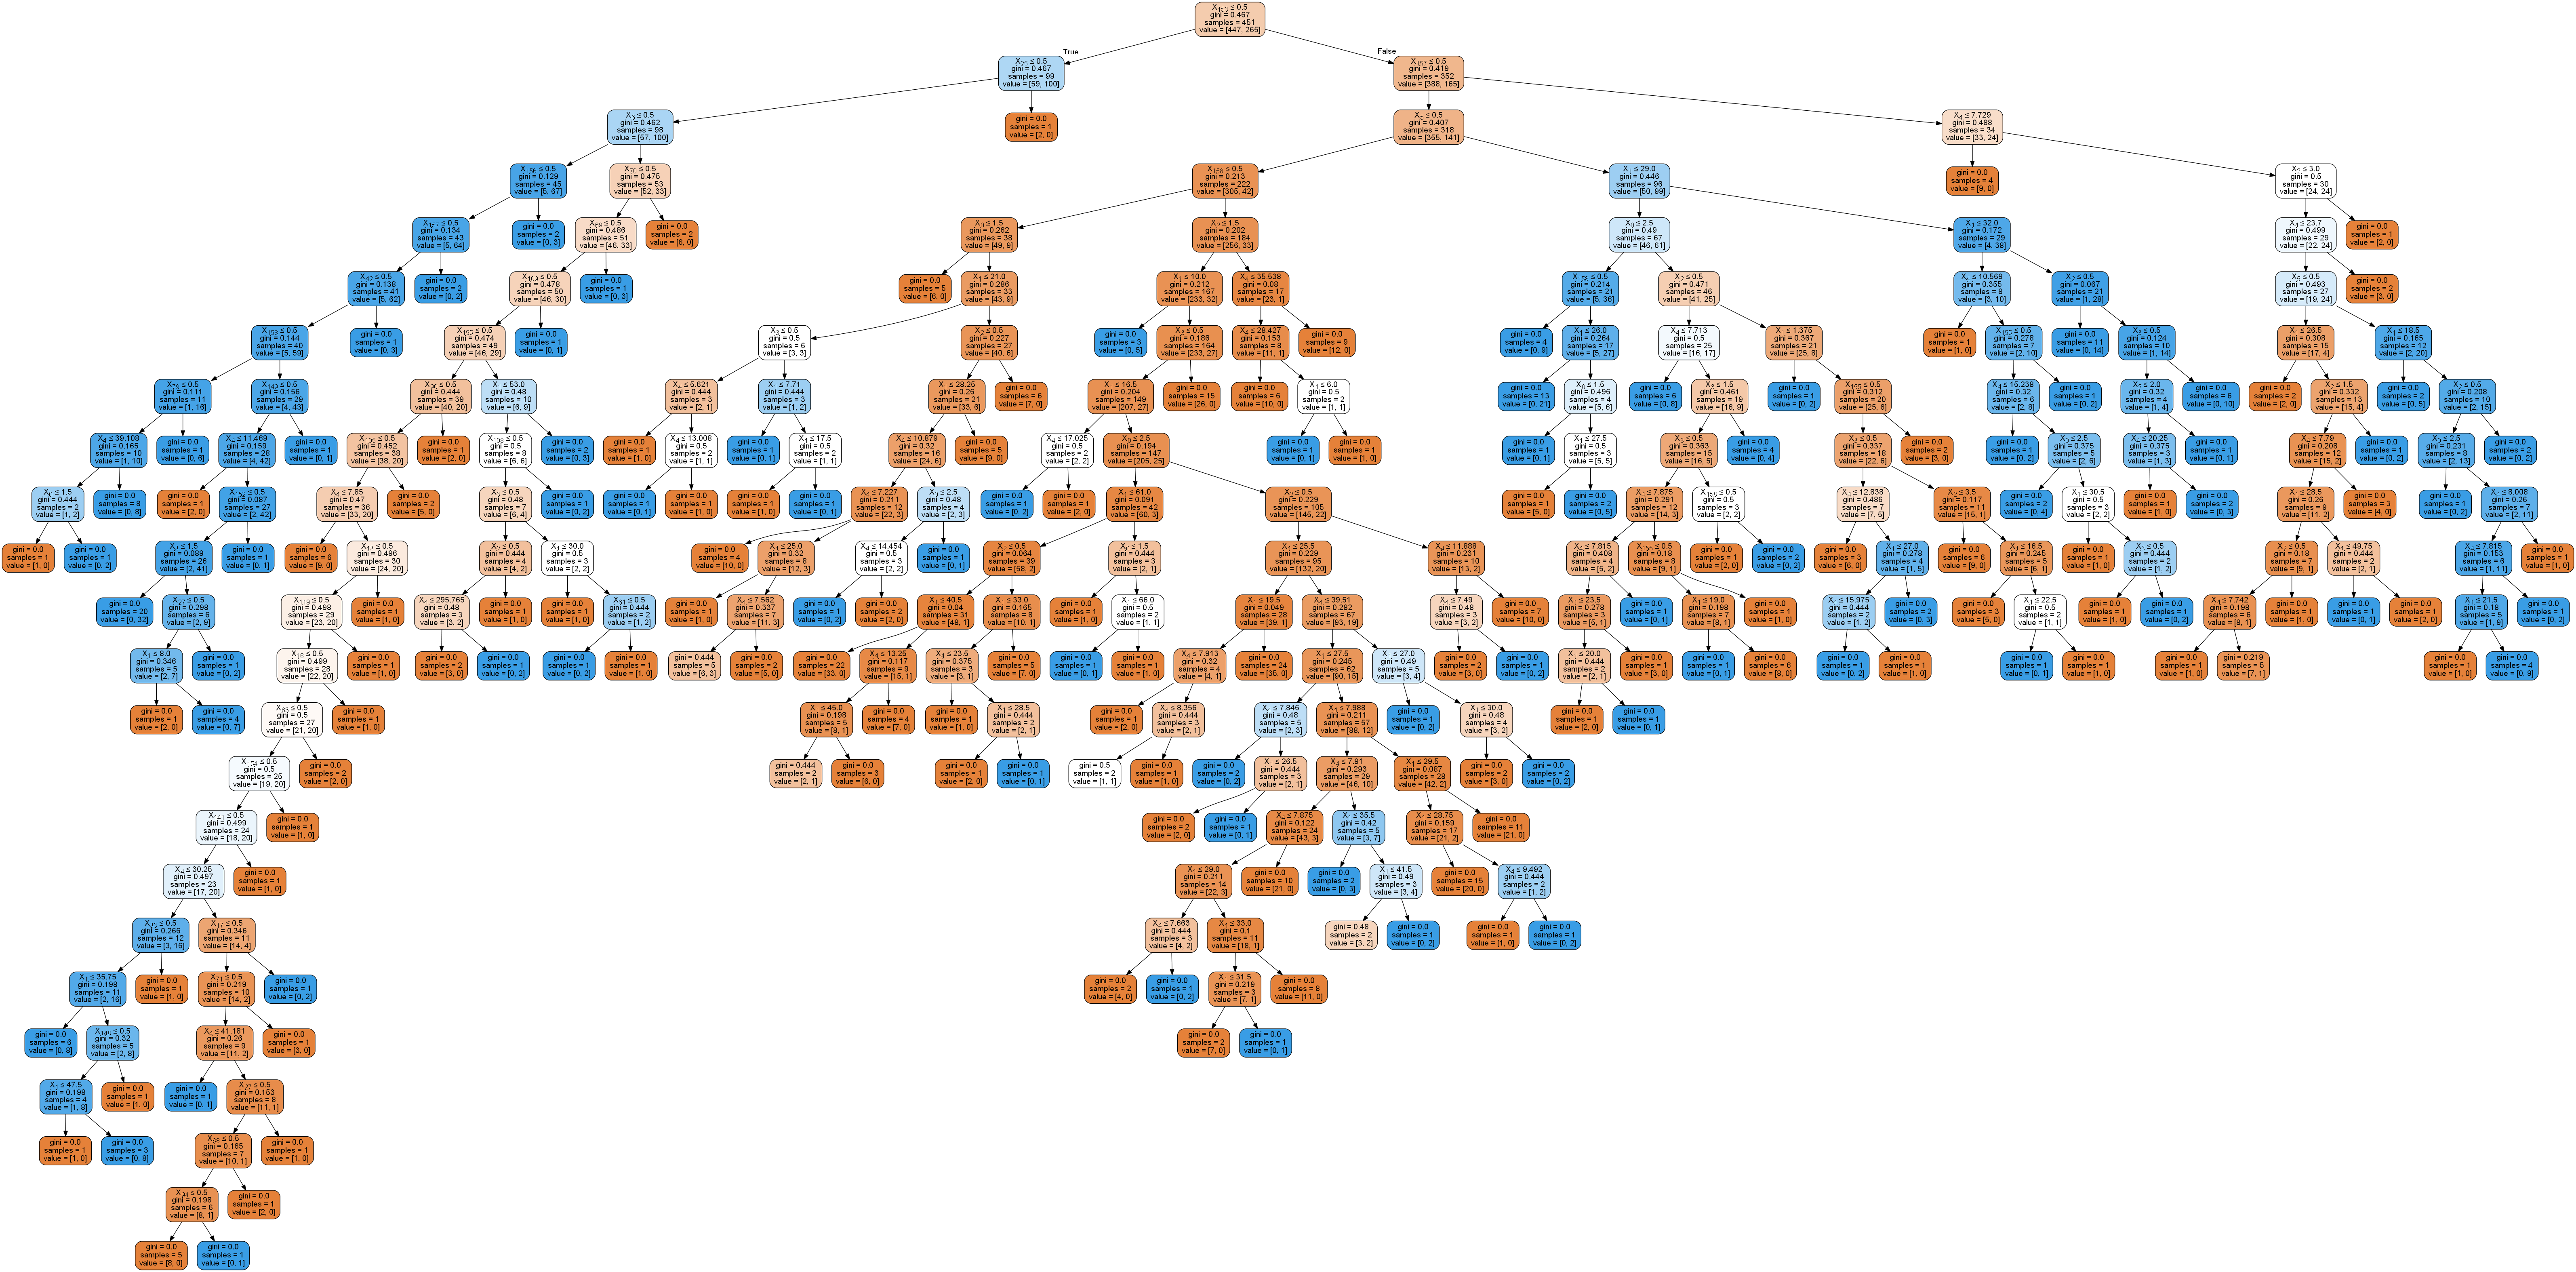

In [35]:
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(model_2.estimators_[0], out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

### Feature Importance

Feature selection  - implicit feature selection whereas models like LASSO is explicit.

A feature’s importance is the increase in the model’s prediction error after we permuted the feature’s values (breaks the relationship between the feature and the outcome).

**What does it mean:** The important features are more correlated with the dependent variable and contribute more variance to the dependent varaible. 

**How does it work:**
1. Train Random Forest Model
2. Find prediction score of model (benchmark score)
3. For each feature, shuffle it's value to alter it and look at prediction performance.
4. Compare it with benchmark score. If the altered feature hurts the score, then it's a bad feature.

If you work with linear models then there is quite simple distinction if feature is "positive" or "negative", because the only impact it can have on the final result is being added (with weight). Nothing more. However, ensemble of decision trees can have arbitrary complex rules for each feature, for example "if book has red cover and have more than 100 pages then if it contains dragons it gets high score" but "if book has blue cover and more than 100 pages then if it contains dragons it gets low score" and so on.

Feature importance only gives you notion which features contributes to the decision, not "which way", because sometimes it will work this, and sometimes the other way.

In [36]:
model_2.feature_importances_

array([6.36961359e-02, 2.07657051e-01, 4.46678792e-02, 3.85831325e-02,
       2.09332080e-01, 1.39141707e-01, 1.28853903e-01, 6.95683842e-04,
       2.74008807e-04, 2.90720190e-04, 1.57305883e-04, 0.00000000e+00,
       2.48738595e-03, 1.99176247e-04, 1.60477588e-03, 0.00000000e+00,
       3.21222233e-04, 1.14469816e-03, 1.42038783e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.82217226e-03, 4.73539931e-04,
       4.92083461e-04, 2.88746948e-04, 2.27729149e-03, 4.72717963e-04,
       2.16901683e-04, 2.51816476e-04, 0.00000000e+00, 3.15005854e-04,
       6.15582271e-04, 3.88080125e-04, 0.00000000e+00, 3.55574018e-04,
       1.27117468e-03, 2.32712552e-04, 1.44116969e-03, 6.84792430e-04,
       1.81627477e-03, 1.33132012e-03, 1.27600632e-04, 7.34997549e-04,
       0.00000000e+00, 5.59027160e-04, 1.83104270e-04, 1.02659101e-03,
       0.00000000e+00, 2.84408521e-04, 7.11138936e-05, 1.11173851e-03,
       0.00000000e+00, 7.66043004e-05, 2.70512324e-03, 2.68507117e-04,
      

Pclass           0.063696
Age              0.207657
SibSp            0.044668
Parch            0.038583
Fare             0.209332
                   ...   
Cabin_T          0.000519
Embarked_C       0.012001
Embarked_None    0.000906
Embarked_Q       0.006281
Embarked_S       0.011650
Length: 159, dtype: float64


<BarContainer object of 20 artists>

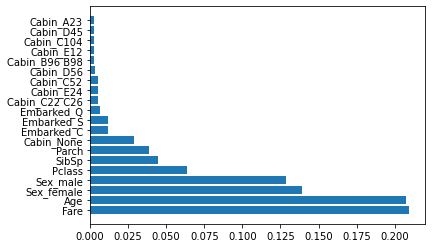

In [37]:
feature_importances = pd.Series(model_2.feature_importances_, index=x.columns)
print(feature_importances)
feature_importances.sort_values(inplace=True,ascending=False)
plt.barh(feature_importances.index.values[:20],feature_importances.values[:20])

#### Combine the categorical features into one feature importance

In [38]:
model_2.feature_importances_.max()

0.2093320804058596

Sex         0.267996
Fare        0.209332
Age         0.207657
Cabin       0.137231
Pclass      0.063696
SibSp       0.044668
Parch       0.038583
Embarked    0.030838
dtype: float64


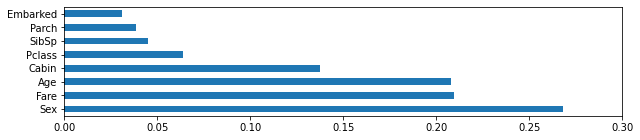

In [39]:
def plot_feature_importance(model, feature_names, autoscale=True, headroom=0.1, width=10, summerized_columns=None):
    
    feature_dict = dict(zip(feature_names, model.feature_importances_))
    
    if summerized_columns:
        for col_name in summerized_columns:
            summed = sum(x for i,x in feature_dict.items() if col_name in i)
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i]
            for i in keys_to_remove:
                feature_dict.pop(i)
            feature_dict[col_name] = summed
    results = pd.Series(feature_dict, index=feature_dict.keys())
    results.sort_values(inplace = True, ascending=False)
    print(results)
    results.plot(kind='barh', figsize=(width, len(results)/4), xlim=(0,.30))

plot_feature_importance(model_2, x.columns, summerized_columns=categorical_variable)

### Partial Dependency Plot(Stree Testing the Model)
#### How is target variable related with important features?
- It is a representation of the variables effect on the target field. 
- It can help explain the directional relationship between the features

**Explanation:**
- PClass: You have a higher chance of survival when you are from PClass 1 or 2. 
- Age: You have a higher chance of survival if you're a young kid, in your early 30's, or a senior.
- Fare: You have a higher chance of survival if you spent more money on ticket price.

In [40]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.impute import SimpleImputer

c:\python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; The function ensemble.plot_partial_dependence has been deprecated in favour of sklearn.inspection.plot_partial_dependence in  0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)
c:\python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)
c:\python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)
c:\python\lib\site-packages\sklearn\utils\deprecation.py:87: 

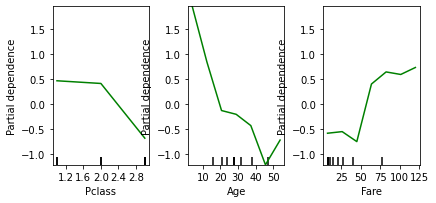

In [41]:
gbc = GradientBoostingClassifier()
titanic_X_column_names = ['Pclass', 'Age', 'Fare']
titanic_X = X_train[titanic_X_column_names]
my_imputer = SimpleImputer()
imputed_titanic_X = my_imputer.fit_transform(titanic_X)

gbc.fit(imputed_titanic_X, y_train)
titanic_plots = plot_partial_dependence(gbc, features=titanic_X_column_names, X=titanic_X, 
                                        feature_names=titanic_X_column_names, grid_resolution=7)

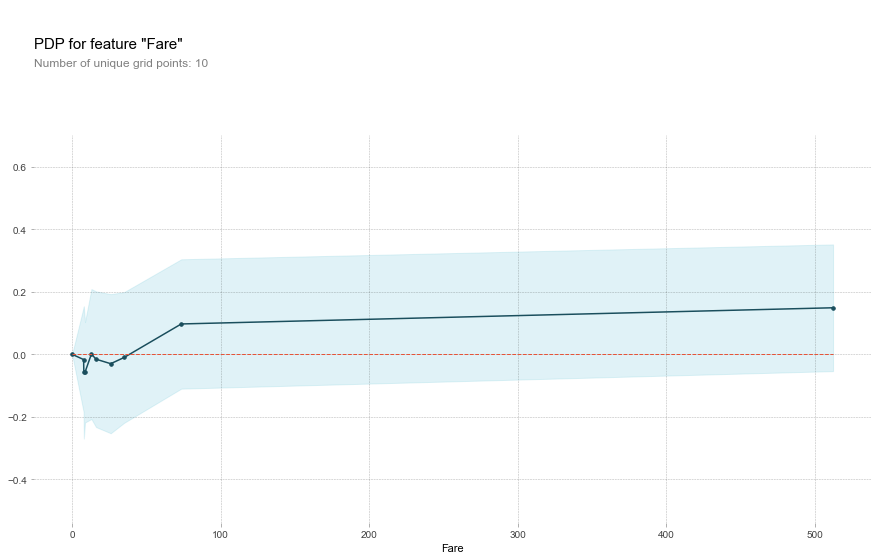

In [42]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=model_2, dataset=X_train, model_features=X_train.columns, feature='Fare')

# plot it
pdp.pdp_plot(pdp_goals, 'Fare')
plt.show()

# Conclusion

**In short:**
- It needs minimal data cleaning
- Works with both regression and classification
- It gives feature importance
- Great for exploratory modeling
- Good baseline model
- Built in cross validation
- Little hyper parameter tuning
- Treats different scaling of features similarly
- Natively detects non linear interactions